- some source code:
1. PCA
2. (https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)
3. Correlation regarding to categorical data
4. (https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib as plt
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import prince
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [2]:
pd.__version__

'1.3.3'

In [3]:
df = pd.read_csv('C:/Users/Jake/PycharmProjects/DSML_Study/data/bank-full.csv')

In [4]:
df.shape

(45211, 2)

In [5]:
name_list = list(df.columns)[0].split(';')
target = list(df.columns)[0]

In [6]:
df[name_list] = df[target].str.split(pat=";", expand=True)

In [7]:
df = df.drop(columns = target)

In [8]:
'removing "" in the dataframe'
df = df.replace('"','', regex =True)
df.columns = df.columns.str.replace('"','')
df.head()

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 1. Knowing the data

In [9]:
def table(my_df):
    total = len(my_df)
    print('Data shape:' , my_df.shape)
    summary = pd.DataFrame(my_df.dtypes, columns = ['data_type'])
    summary['Missing data in %'] = my_df.isnull().sum().values/total *100
    summary['Unique'] = my_df.nunique().values
    summary['First Value'] = my_df.loc[0].values
    summary['Second Value'] = my_df.loc[1].values
    summary['Third Value'] = my_df.loc[2].values

    return summary

def intersection(lst_1, lst_2):
    lst_3 = [value for value in lst_1 if value in lst_2]
    return lst_3

t = table(df)
temp_df = df

Data shape: (45211, 18)


In [10]:
t

,data_type,Missing data in %,Unique,First Value,Second Value,Third Value
year,int64,0.0,3,2008,2008,2008
age,object,0.0,77,58,44,33
job,object,0.0,12,management,technician,entrepreneur
marital,object,0.0,3,married,single,married
education,object,0.0,4,tertiary,secondary,secondary
default,object,0.0,2,no,no,no
balance,object,0.0,7168,2143,29,2
housing,object,0.0,2,yes,yes,yes
loan,object,0.0,2,no,no,yes
contact,object,0.0,3,unknown,unknown,unknown


In [11]:
t.tail(10)
#t[t['Missing data in %'] >= 80]
#print(t[:25])
#print(type(t))

,data_type,Missing data in %,Unique,First Value,Second Value,Third Value
loan,object,0.0,2,no,no,yes
contact,object,0.0,3,unknown,unknown,unknown
day,object,0.0,31,5,5,5
month,object,0.0,12,may,may,may
duration,object,0.0,1573,261,151,76
campaign,object,0.0,48,1,1,1
pdays,object,0.0,559,-1,-1,-1
previous,object,0.0,41,0,0,0
poutcome,object,0.0,4,unknown,unknown,unknown
y,object,0.0,2,no,no,no


**Categorical Features - Transaction**

- Job
- Marital
- Education
- Default
- Housing
- Loan
- Contact
- Month (could convert to numerical)
- Poutcome
- y (the outcome that we need to predict)

First we pay attention to the distribution of the data.

# 2. Target Distribution


In [12]:
list1 = df['y'].values.tolist()
yes_count = 0
no_count = 0
for counter in list1:
    if counter == 'yes':
        yes_count +=1
    else:
        no_count +=1
yes_ratio = yes_count/len(list1)
no_ratio= no_count/len(list1)

7.548118737001324


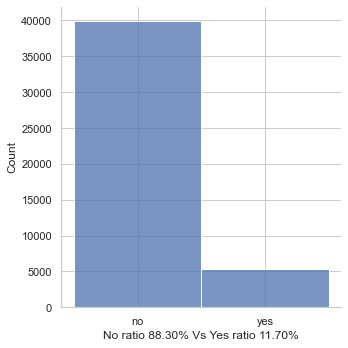

In [13]:
sns.set_theme(style = 'whitegrid')
ax = sns.displot(data = df['y'])
ax.set_xlabels('No ratio ' + '{:1.2f}%'.format(no_ratio*100) + ' Vs ' + 'Yes ratio '+'{:1.2f}%'.format(yes_ratio*100))
my_scale_pos_weight = no_count/yes_count
print(my_scale_pos_weight)

We have only 11.7% 'yes' in our dataset, hence the data is somehow imbalanced.

Now let's take a look at the distribution of some numerical feature.

In [14]:
numeric_list = ['balance','duration', 'pdays', 'previous', 'age', 'campaign', 'day']

df['balance'] = pd.to_numeric(df['balance'])
df['duration'] = pd.to_numeric(df['duration'])
df['pdays'] = pd.to_numeric(df['pdays'])
df['previous'] = pd.to_numeric(df['previous'])
df['age'] = pd.to_numeric(df['age'])
df['campaign'] = pd.to_numeric(df['campaign'])
df['day'] = pd.to_numeric((df['day']))

<AxesSubplot:ylabel='balance'>

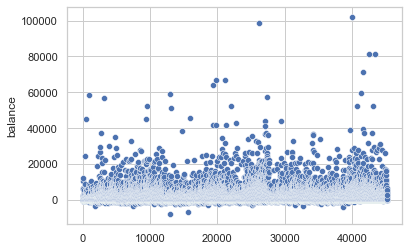

In [15]:
sns.scatterplot(data = df['balance'])

'pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)'

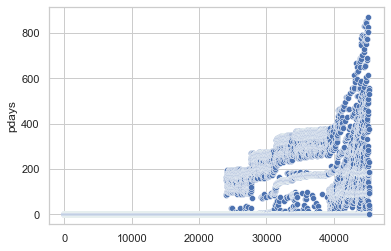

In [16]:
sns.scatterplot(data = df['pdays'])
'pdays: number of days that passed by after the client was last contacted from ' \
'a previous campaign (numeric, -1 means client was not previously contacted)'

In [17]:
def Calculate_outliers(df_num):
    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    cut = data_std * 3
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]

    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points

    return outliers_total

In [18]:
out_balance = Calculate_outliers(df['balance'])

Identified lowest outliers: 1
Identified upper outliers: 744
Total outlier observations: 745
Non-outlier observations: 44466
Total percentual of Outliers:  1.6754


In [19]:
minimal = min(out_balance)
pos_out = out_balance.copy()
pos_out.remove(minimal)
min(pos_out) #get the positive minimal of the outliers

10500

In [20]:
'Here we list an example for one of outliers'
df.loc[df['balance'] == out_balance[3]]

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
446,2008,39,technician,single,unknown,no,45248,yes,no,unknown,6,may,1623,1,-1,0,unknown,yes


- In general, we will avoid the outliers and has more confidence in our distribution regarding to balance if
we set our balance value in the range(0, 10558)
- Notice that the ourliers only constitude 1.68% of the whole data and we have 40K rows in total.

In [21]:
out_pdays = Calculate_outliers(df['pdays'])

Identified lowest outliers: 0
Identified upper outliers: 1723
Total outlier observations: 1723
Non-outlier observations: 43488
Total percentual of Outliers:  3.962


In [22]:
min(out_pdays)

341

In [23]:
'Here list some outliers as previous'
df.loc[df['pdays'] == out_pdays[0]].head(3)

,year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
32111,2009,32,services,married,secondary,no,1129,yes,no,cellular,15,apr,903,2,341,2,failure,yes
33073,2009,36,blue-collar,married,secondary,no,1589,yes,no,cellular,20,apr,345,2,341,6,other,no
33074,2009,32,admin.,married,secondary,no,413,yes,no,cellular,20,apr,95,3,341,2,failure,no


Now we try to deal with categorical data
- For day and month, since the column for year is missing, we can not transfer the day and month comlumn to datetime data type
- Hence, we regard the day as numeric data and month as categorical data and group by season for further investigation.

- First we try xgboost, note xgboost has support for categorical data using gpu_hist and gpu_predictor.


# 3. Feature Engineering

- First encode the categorical data and drop the outliers for pdays, it is reasonable since

In [24]:
one_hot_columns = ['job', 'marital', 'education', 'contact', 'poutcome', 'month']

In [25]:
one_hot_df = df[one_hot_columns]
one_hot_df = pd.get_dummies(one_hot_df, columns=one_hot_columns)
df_drop = df.drop(one_hot_columns, axis = 1)
df_one_hot = pd.concat([df_drop, one_hot_df], axis=1)

- We change the binary categorical data to numerical data

In [26]:
binary_list = ['default', 'housing', 'loan', 'y']
df_one_hot[binary_list] = df_one_hot[binary_list].replace(to_replace='yes', value=1)
df_one_hot[binary_list] = df_one_hot[binary_list].replace(to_replace='no', value=0)
df_one_hot.shape

(45211, 50)

In [27]:
df_one_hot.head(1)


,year,age,default,balance,housing,loan,day,duration,campaign,pdays,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,2008,58,0,2143,1,0,5,261,1,-1,...,0,0,0,0,0,0,1,0,0,0
